## Spam Ham Classification - Naive Bayes

### Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re,string,collections
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report

### Gaining Intuition

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [6]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [7]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [8]:
df.shape

(5572, 2)

### Data Cleaning

#### Data Processing
- Removing Punctuations
- Links
- Stop words
- Performing Lemmatization

In [9]:
df['Message'] = [re.sub(r'[https|www]\S+', "", msg) for msg in df['Message']]
df['Message'].head()

0    Go un jurong  crazy.. Available only in bugis ...
1                           Ok lar... Joking  u oni...
2    Free en in 2 a  comp   FA Cup final  21 May 20...
3                         U dun   early  U c already  
4                Nah I don't   goes  u  lives around  
Name: Message, dtype: object

In [10]:
# Since I found individual words like '..' , '...' I'm removing everything that starts with '.' & repeats more than once...
df['Message'] = [re.sub(r'\.{1,}', "", msg) for msg in df['Message']]
df['Message'].head()

0    Go un jurong  crazy Available only in bugis n ...
1                                 Ok lar Joking  u oni
2    Free en in 2 a  comp   FA Cup final  21 May 20...
3                         U dun   early  U c already  
4                Nah I don't   goes  u  lives around  
Name: Message, dtype: object

Processing words

In [11]:
stop_words = stopwords.words('english')
lemma = WordNetLemmatizer()
def processWords(message: str):
    words = message.lower()
    words = word_tokenize(words)
    # Removing punctuations
    words = [word for word in words if word not in string.punctuation]
    # Single letters and digits need'nt be considered
    words = [word for word in words if len(word)>1]
    # Removing all of the stop words
    words = [word for word in words if word not in stop_words]
    # Lemmatizing the words...
    words = [lemma.lemmatize(word) for word in words]

    return words


Separating spam and ham messages for easy understanding and visualization

In [12]:
# Separating
spamMessages,hamMessages = df[df['Category'] == 'spam']['Message'], df[df['Category'] == 'ham']['Message']
# Processing
spamMessages,hamMessages = [processWords(message) for message in spamMessages],[processWords(message) for message in hamMessages ]

### Visualization

Counting words in each messages

In [13]:
# Calculating frequence for each words in order to represent it in the bar chart
def count_Words(Message: list):
    counter = collections.OrderedDict()
    for words in Message:
        for word in words:
            counter[word] = counter.get(word,0)+1
    return counter

In [14]:
spam_words_dict = count_Words(spamMessages)
ham_words_dict = count_Words(hamMessages)

In [15]:
# Plotting data in bar chart for better understanding

def bar_chart_words(count_dict: dict, top=10, messages_type="", color="#1f77b4"):
    # Sorting the keys with high values in descending order to vizualize
    words = np.array(sorted(count_dict.items(), key = lambda x: -x[1]))[:top]
    top_words = words[::,0] # [::,0] - Represents column 1
    top_words_count = words[::,1] #[::,1] Represents column 2

    # Graph representation
    plt.title(f'Top {top} most common words in {messages_type}messages')
    plt.xlabel(f'{messages_type} word count')
    plt.barh(top_words,top_words_count, color = color)

Visualization with `Bar Chart`

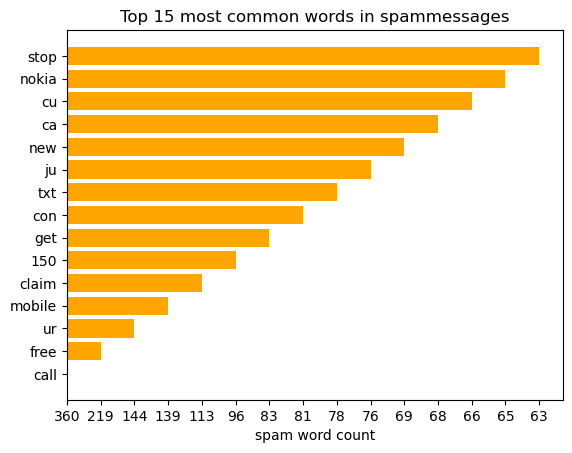

In [16]:
# spam
bar_chart_words(spam_words_dict, top = 15, messages_type='spam',color = 'orange')

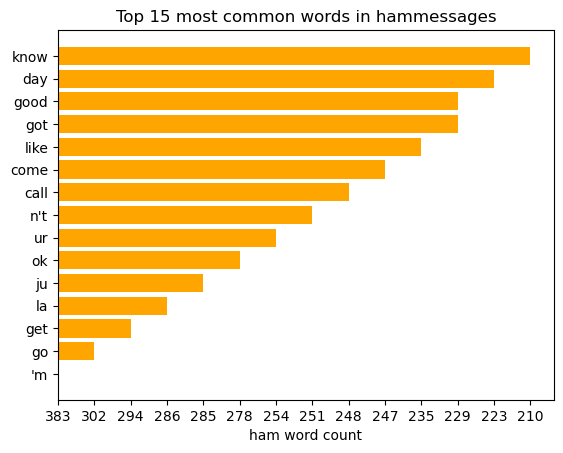

In [17]:
# ham
bar_chart_words(ham_words_dict, top = 15, messages_type='ham',color = 'orange')

Visualizing with `word cloud` gives even more clear view

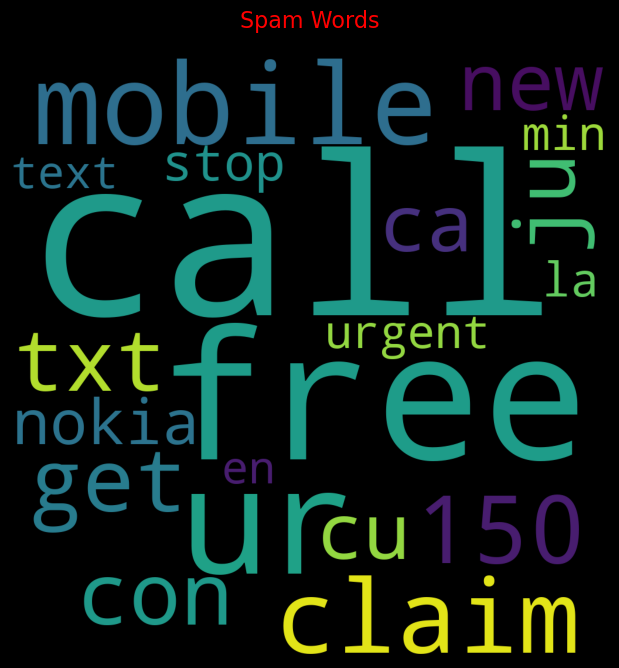

In [18]:
# Visualizing with word cloud gives even more clear view
# Spam
wc = WordCloud(width=1024,height = 1024, max_words=20).generate_from_frequencies(spam_words_dict)
plt.figure(figsize=(8,6),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.text(0.5, 1.05, 'Spam Words', color='Red', fontsize=16, ha='center', transform=plt.gca().transAxes)
plt.show()

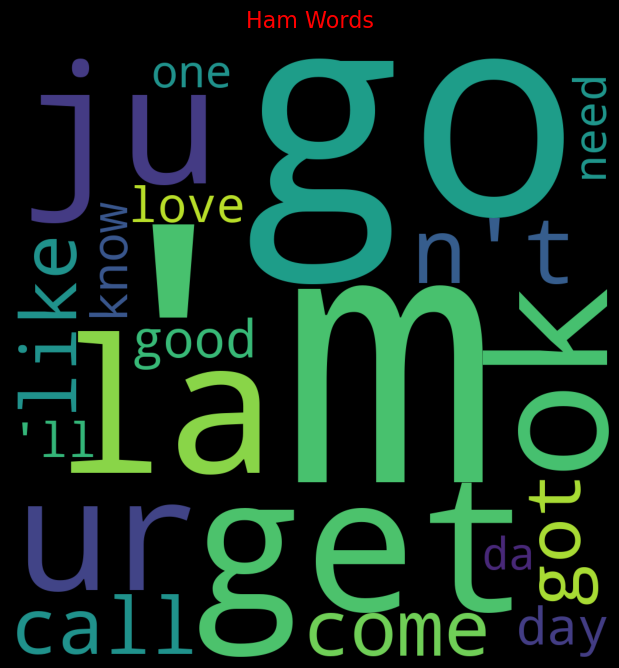

In [19]:
# Ham
wc = WordCloud(width=1024,height = 1024, max_words=20).generate_from_frequencies(ham_words_dict)
plt.figure(figsize=(8,6),facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.text(0.5, 1.05, 'Ham Words', color='Red', fontsize=16, ha='center', transform=plt.gca().transAxes)
plt.show()

In [20]:
# Combining spam and ham messages after vizualization
allMessages = spamMessages + hamMessages
all_words = count_Words(allMessages)
# Now the messages are ready to be vectorized...
allMessages = [' '.join(msglist) for msglist in allMessages]

### Training the Model

#### Splitting the model

In [21]:
allMessages[:2]

["free en comp fa cup final 21 may 2005 text fa 87121 receive en que ra 08452810075over18 's",
 "freem hey darling back 'd like fun tb ok xxx £150 rcv"]

Defining spam column that represents the one hot encoding of the `Category` column

In [22]:
df['spam'] = df.Category.apply(lambda x: 1 if x== 'spam' else 0)
df.head()

,Category,Message,spam
0,ham,Go un jurong crazy Available only in bugis n ...,0
1,ham,Ok lar Joking u oni,0
2,spam,Free en in 2 a comp FA Cup final 21 May 20...,1
3,ham,U dun early U c already,0
4,ham,Nah I don't goes u lives around,0


#### Vectorize

In [23]:
vector = CountVectorizer()
# Since the algorithm can only take numbers as arguments...
# Since X_train is an array of array of strings, we should change that to array of strings such that it is vectorized
X = vector.fit_transform(allMessages)
X.toarray()[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
# splitting train & test
X_train,X_test,Y_train,Y_test = train_test_split(X,df.spam,test_size=0.25)

In [25]:
X_train.shape,Y_train.shape

((4179, 5132), (4179,))

Fitting model

In [26]:
model = MultinomialNB()
model.fit(X_train,Y_train)

MultinomialNB()

### Prediction and Evaluation

##### Measures

In [27]:
Y_pred = model.predict(X_test)
Y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
print(classification_report(y_true = Y_test, y_pred = Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1189
           1       0.13      0.04      0.07       204

    accuracy                           0.82      1393
   macro avg       0.49      0.50      0.48      1393
weighted avg       0.75      0.82      0.78      1393



In [29]:
matrix = confusion_matrix(y_pred = Y_pred,y_true = Y_test)
matrix

array([[1130,   59],
       [ 195,    9]], dtype=int64)

Vizualization

<Axes: >

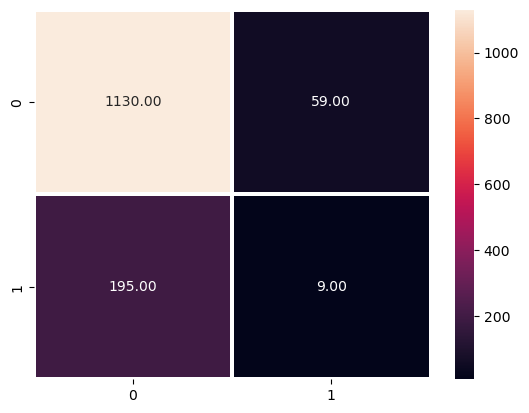

In [30]:
sns.heatmap(matrix,annot=True,fmt=".2f",linewidths=1.5)

Ofcourse the model seems to be biased on ham messages for this particular data set since, we have only limited spam messages. But excluding `NLP` seems to be providing better results for this particular dataset......refer: https://youtu.be/nHIUYwN-5rM